<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/End_to_end_Masked_Language_Modeling_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tf-nightly

     |████████████████████████████████| 454.3MB 37kB/s 
     |████████████████████████████████| 1.2MB 43.5MB/s 
     |████████████████████████████████| 6.0MB 53.6MB/s 
     |████████████████████████████████| 4.0MB 44.2MB/s 
     |████████████████████████████████| 471kB 47.1MB/s 
     |████████████████████████████████| 4.0MB 41.7MB/s 
     |████████████████████████████████| 3.9MB 50.2MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: gast 0.3.3
    Uninstal

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  40.4M      0  0:00:01  0:00:01 --:--:-- 40.4M


In [ ]:
a = glob.glob("aclImdb/train/pos/*")[0]
b = glob.glob("aclImdb/train/pos/*")[1]

In [ ]:
with open(a) as f:
  print(f.read(-1))

"The Garden of Allah" is a prime example of "popular women's literature", turn of the XXth century style, combining all the power of unbridled erotic and exotic reveries with the stimulating glamour of fake mysticism and the sado-masochistic bite of Catholic guilt. Just as Jane Eyre couldn't really be happy until her castle burned down around her and her lover was permanently maimed for his sins, or the heroine of "Rebecca" couldn't find true fulfillment in her marriage until her lordly husband was put on trial for the murder of his first wife (and her castle burned down around her), or poor Psyche couldn't leave well enough alone and had to extract Cupid's secret at all costs, Domini, the devout Catholic heroine of this piece of tripe, can only find true sexual realization by inadvertently marrying a man who has renounced his sacred religious vows. Like all such narratives aiming to stimulate the female reader and induce the vapours, this one relies on the oldest tricks in the book: b

In [ ]:
with open(b) as f:
  print(f.read(-1))
  for line in f:
    print(line)

This is a pretty decent example of film noir. The setting is the early 50's with the Communists trying to steal weapon secrets from the US Government.<br /><br />Richard Widmark is the suave pickpocket without scruples. He gives a pretty decent performance but there is nothing A-List about him. The interesting thing was that he was not only an anti-hero but through most of the film, an unlikeable anti-hero. That is not very normal. Jean Peters gave a so-so performance as the hooker with the heart of gold. That great character actress Thelma Ritter shines as the stool-pigeon.<br /><br />The plot had its fair share of twists and turns, wisecracks and tough talk. There is a fight scene near the end of the movie (in the subway station) that was pretty gritty and exciting.<br /><br />I think noir fans (like myself) will enjoy this film. For non-noir viewers, it may seem a little dated and the whole Commie thing a tad overdone.


In [ ]:
def get_text_list_from_files(files):
  text_list = []
  for name in files:
    with open(name) as f:
      for line in f:
        text_list.append(line)
  return text_list


def get_data_from_text_files(folder_name):

  pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
  pos_texts = get_text_list_from_files(pos_files)
  neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
  neg_texts = get_text_list_from_files(neg_files)
  df = pd.DataFrame(
      {
          "review": pos_texts + neg_texts,
          "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts)
      }
  )
  df = df.sample(len(df)).reset_index(drop = True)

  return df

train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = train_df.append(test_df)

In [ ]:
all_data

,review,sentiment
0,I had to register for IMDb just to post a comm...,1
1,"I've been watching ""Dick Tracy"" for years, and...",0
2,"What an absolutely stunning movie, if you have...",0
3,Adolf Hitler's maniacal desire to impose his w...,0
4,Goodnight Mister Tom is so beautifully filmed ...,0
...,...,...
24995,"I just saw this film last night, and I have to...",0
24996,I started off being interested somewhat in the...,1
24997,I'm not sure if these other people saw the mov...,0
24998,This is another enjoyable and entertaining Hit...,0


In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size
      max_seq (int): Maximum sequence lenght.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer


vectorize_layer = get_vectorize_layer(
    all_data.review.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Get mask token id for masked language model
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]


def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()


def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights


# We have 25000 examples for training
x_train = encode(train_df.review.values)  # encode reviews with vectorizer
y_train = train_df.sentiment.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# We have 25000 examples for testing
x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Build dataset for end to end model input (will be used at the end)
test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_df.review.values, y_test)
).batch(config.BATCH_SIZE)

# Prepare data for masked language model
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

In [ ]:
def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc


loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")


class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 256, 128)     3840000     input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 256, 128)     0           word_embedding[0][0]             
__________________________________________________________________________________________________
encoder_0/multiheadattention (M (None, 256, 128)     66048       tf.__operators__.add[0][0]       
                                                                 tf.__operators__.

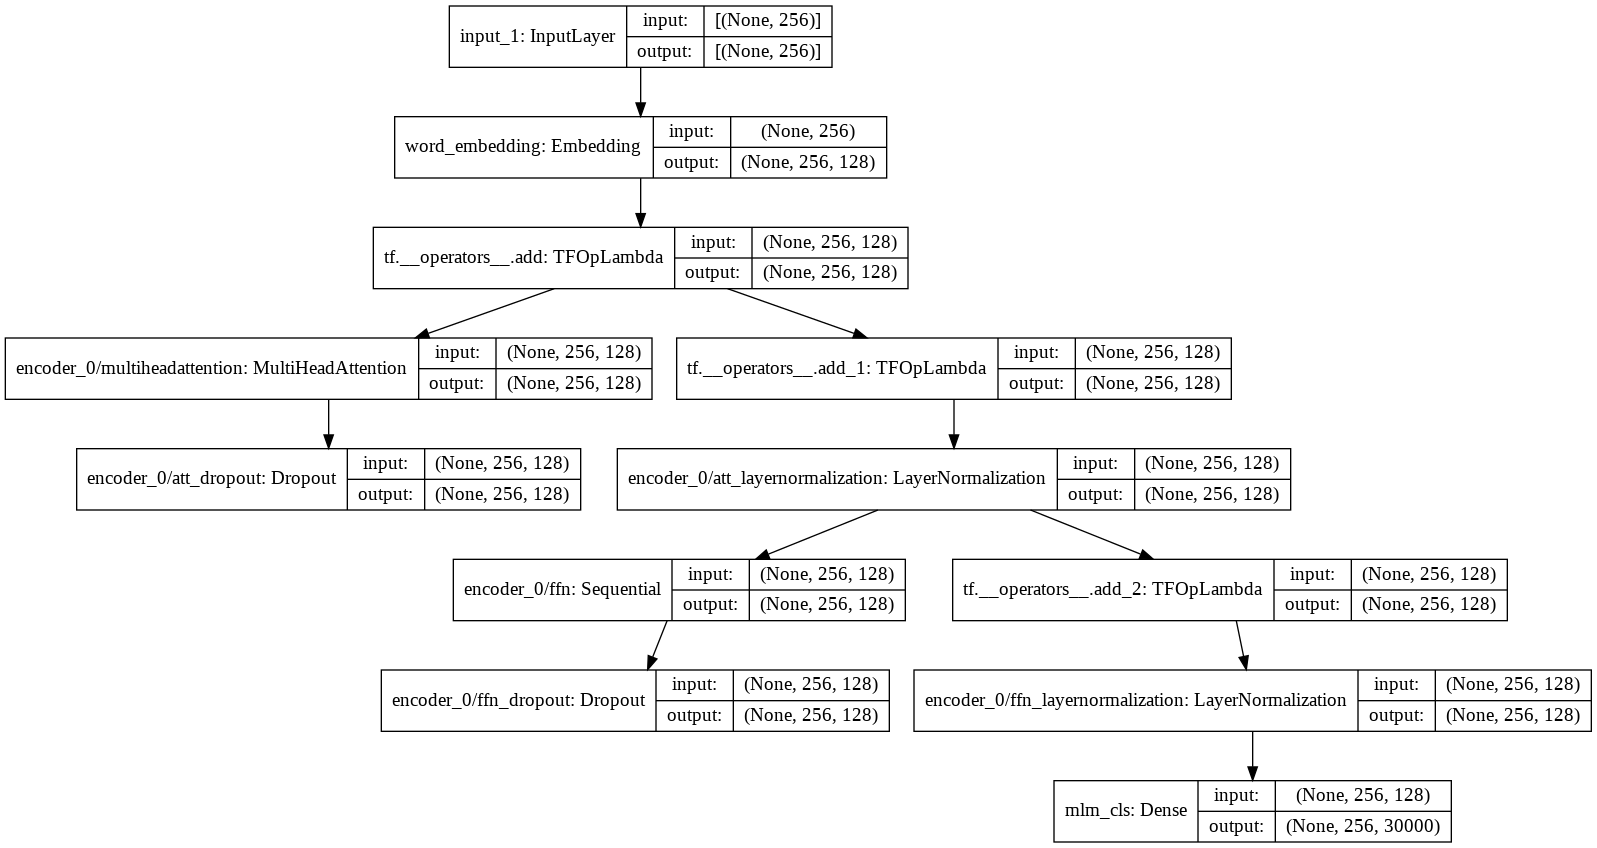

In [ ]:
keras.utils.plot_model(bert_masked_model,show_shapes=True)

In [ ]:
bert_masked_model.fit(mlm_ds, epochs=5, callbacks=[generator_callback])
bert_masked_model.save("bert_mlm_imdb.h5")

In [ ]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "bert_mlm_imdb.h5", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = tf.keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0/ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False

def create_classifier_bert_model():
  inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)
  sequence_output = pretrained_bert_model(inputs)
  pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
  hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
  outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
  classifer_model = keras.Model(inputs, outputs, name="classification")
  optimizer = keras.optimizers.Adam()
  classifer_model.compile(
      optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
  )
  return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()


In [ ]:
# Train the classifier with frozen BERT stage
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

# Unfreeze the BERT model for fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

In [ ]:
def get_end_to_end(model):
    inputs_string = keras.Input(shape=(1,), dtype="string")
    indices = vectorize_layer(inputs_string)
    outputs = model(indices)
    end_to_end_model = keras.Model(inputs_string, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


end_to_end_classification_model = get_end_to_end(classifer_model)
end_to_end_classification_model.evaluate(test_raw_classifier_ds)